# Measuring Non-Binary Treatment Discrimination Analysis

#### Importing packages

In [1]:
import os
os.chdir('../')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles
from utils.notebook_helpers import *
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', 10)
pd.set_option("display.precision", 5)

In [4]:
bundles.aaai2024()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.3, 2.039512162874653),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 9,
 'axes.labelsize': 9,
 'legend.fontsize': 7,
 'xtick.labelsize': 7,
 'ytick.labelsize': 7,
 'axes.titlesize': 9}

In [5]:
plt.rcParams.update(bundles.aaai2024())
# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})

In [7]:
root_path = '_models_trained/causal_nf'

#### Running notes
To run for a new dataset, *copy* all the cells that are for a particular existing dataset, e.g., German, and paste them in the bottom of the notebook. So, from the cell that says German credit *all the way* to the cell titled "Downstream effect of path-specific treatment: $Y(S^F,X^F,Z(do(S=S^{CF}), do(X=X^F)))$". 

*OR*

Copy the above mentioned cells to a new notebook to have the results of a dataset in a separate notebook.

---

Then, when loading `data_df`, call `load\_csv\_file` with proper data name and the split. If you want to see for the entire data, use `all`.

Similarly, load the yaml by using the proper data name.

#### Important note regarding distribution plots!
You need to use proper `plot\_params`. E.g., in German, I use `plot_params = {'rows': 1, 'cols': 3, 'figsize': (7, 1.7), 'plot_idx_legend': 1}`. Importantly, pass *proper* cols, it should be the same as the *number of treatment decisions*!


# German credit


In [8]:
# choose: train, val, test, all
data_df = load_csv_file(root_path, 'german', 'all')
params = load_yaml_config(root_path, 'german')

In [9]:
treatment_col_idxs = range(params['dataset__num_sensitive'] + params['dataset__num_covariate'], 
                           params['dataset__num_sensitive'] + params['dataset__num_covariate'] + params['dataset__num_treatment'])

total_features = params['dataset__num_sensitive'] + params['dataset__num_covariate'] + params['dataset__num_treatment'] + 1

treatment_features = [c.split('_F')[0] for c in data_df.columns[treatment_col_idxs]]

print('Treatment features:', treatment_features)

gender_col_name = data_df.columns[0].split('_F')[0]
class_col_name = data_df.columns[total_features - 1].split('_F')[0]

Treatment features: ['duration', 'credit_amount', 'installment_commitment']


#### Direct and Total Discrimination

For each group $S^F=0$ and $S^F=1$, Total Treatment Discrimination is:

$TTD_{S^F \in [0,1]} = Z^{CF}(do(S=S^{CF})) - Z^F$

Similarly, the Direct Treatment Discrimination is measured with respect to the path-specific of the treatment as:

$DTD_{S^F \in [0, 1]} = Z^{SPCF}(do(S=S^{CF}), do(X=X^F)) - Z^F$

##### a. Plot and get results dict for TTD and DTD

In [11]:
plot_params = {'rows': 1, 'cols': 3, 'figsize': (7, 1.7), 'plot_idx_legend': 1}
result_dict = dtd_itd_analysis(data_df, params, plot=False, plot_params=plot_params)

##### b. Scatter plots

In [12]:
df = data_df

treatment_vals_F_0 = df[df[f'{gender_col_name}_F'] == 0][
[f'{c}_F' for c in treatment_features]].to_numpy()
treatment_vals_CF_0 = df[df[f'{gender_col_name}_F'] == 0][
[f'{c}_CF' for c in treatment_features]].to_numpy()
treatment_vals_PSDT_0 = df[df[f'{gender_col_name}_F'] == 0][
        [f'{c}_PSDT' for c in treatment_features]].to_numpy()

td_vals_0 = treatment_vals_CF_0 - treatment_vals_F_0
new_dtd_vals_0 = treatment_vals_PSDT_0 - treatment_vals_F_0

treatment_vals_F_1 = df[df[f'{gender_col_name}_F'] == 1][
    [f'{c}_F' for c in treatment_features]].to_numpy()
treatment_vals_CF_1 = df[df[f'{gender_col_name}_F'] == 1][
    [f'{c}_CF' for c in treatment_features]].to_numpy()
treatment_vals_PSDT_1 = df[df[f'{gender_col_name}_F'] == 1][
        [f'{c}_PSDT' for c in treatment_features]].to_numpy()

td_vals_1 = treatment_vals_CF_1 - treatment_vals_F_1
new_dtd_vals_1 = treatment_vals_PSDT_1 - treatment_vals_F_1

##### c. Print TD and DTD tables

In [13]:
for k in result_dict.keys():
    res = result_dict[k]
    cols = [f'{k}'] + [c for c in treatment_features]
    rows = []
    for meas in ['TD', 'DTD']:
        val_row = {cols[0]: meas}
        i = 1
        for c in treatment_features:
            val_row[cols[i]] = f'{res[meas][c][0]}+/-{res[meas][c][1]}'
            i += 1
        rows.append(val_row)
    df = pd.DataFrame(rows)
    print(df)
    print('-----------------------------------------------------------------')
    

  Overall                                   duration  \
0      TD  -0.32521140000000015+/-3.3507759304784126   
1     DTD    -0.2760340000000001+/-3.073086454016232   

                            credit_amount  \
0  -92.79789999999991+/-977.1157497964738   
1  -95.38485999999997+/-877.4531931779364   

                          installment_commitment  
0   -0.0002646500000000884+/-0.39668381647826145  
1  -0.00024009999999990983+/-0.39722475384621564  
-----------------------------------------------------------------
  gender 0                                  duration  \
0       TD    1.2945795000000002+/-2.421344375191117   
1      DTD  0.46148479999999914+/-2.7245204662967595   

                            credit_amount  \
0  253.34230000000002+/-767.9566100869523   
1           164.65805+/-749.2570989254076   

                        installment_commitment  
0  0.0010302499999998993+/-0.33810819323392866  
1   0.0009528500000000051+/-0.3367224414578877  
------------------------

#### Downstream effect of Total treatment discrimination ($TTD_E$): $Y(S^F,X^F,do(Z=Z^{CF}))$

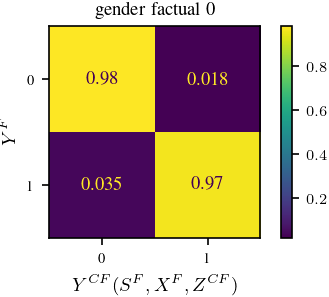

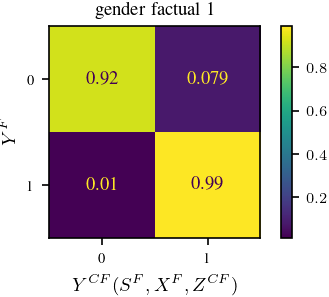

In [14]:
for gender_val in [0, 1]:
    sens_0 = data_df[data_df[f'{gender_col_name}_F'] == gender_val]
    cm = confusion_matrix(sens_0[f'{class_col_name}_F'], sens_0[f'{class_col_name}_TTD'], labels=[0, 1], normalize='true')  # normalize='true'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.ylabel('$Y^F$')
    plt.xlabel('$Y^{CF}(S^{F},X^{F},Z^{CF})$')
    plt.title(f'{gender_col_name} factual {gender_val}')
    plt.show()

#### Downstream effect of direct treatment discrimination (DTD_E): $Y(S^F,X^F,Z^{SPCF}(do(S=S^{CF}), do(X=X^F)))$

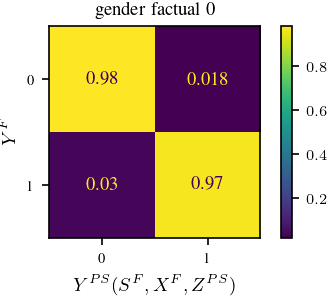

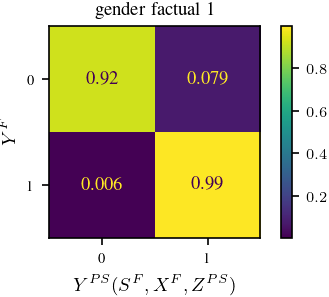

In [15]:
for gender_val in [0, 1]:
    sens_0 = data_df[data_df[f'{gender_col_name}_F'] == gender_val]
    cm = confusion_matrix(sens_0[f'{class_col_name}_F'], sens_0[f'{class_col_name}_PSDT'], labels=[0, 1], normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.ylabel('$Y^F$')
    plt.xlabel('$Y^{PS}(S^{F},X^{F},Z^{PS})$')
    plt.title(f'{gender_col_name} factual {gender_val}')
    plt.show()

---------